In [1]:
# Se importan las librerias necesarias para el proyecto
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Libreria para implementar Deep learning
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

c:\Users\Katherine\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Katherine\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [70]:
# Cargar datos desde el archivo CSV
datos = pd.read_csv('cultivos6.csv', sep=";")
datos

,Fecha,Hora,Theta
0,09/07/2021,00:19:48,"38,35"
1,09/07/2021,00:39:46,"38,35"
2,09/07/2021,00:59:46,"38,35"
3,09/07/2021,01:19:53,"38,35"
4,09/07/2021,01:40:01,"38,35"
...,...,...,...
53281,17/08/2023,06:06:14,"35,3"
53282,17/08/2023,06:26:12,35
53283,17/08/2023,06:46:11,"34,7"
53284,17/08/2023,07:06:09,35


In [71]:
# Tratamiento de fechas
datos['Fecha_Hora'] = pd.to_datetime(datos['Fecha'] + ' ' + datos['Hora'], dayfirst=True)
datos = datos.drop(['Fecha', 'Hora'], axis=1)
columnas = ['Fecha_Hora'] + [col for col in datos if col != 'Fecha_Hora']
datos = datos[columnas]
datos.head()

,Fecha_Hora,Theta
0,2021-07-09 00:19:48,"38,35"
1,2021-07-09 00:39:46,"38,35"
2,2021-07-09 00:59:46,"38,35"
3,2021-07-09 01:19:53,"38,35"
4,2021-07-09 01:40:01,"38,35"


In [72]:
# Reemplazar comas por puntos y convertir a tipo float
datos[['Theta']] = datos[['Theta']].apply(lambda x: x.str.replace(',', '.')).astype(float)
# Verificar si 'Fecha_Hora' está en las columnas antes de establecerlo como índice
if 'Fecha_Hora' in datos.columns:
    # Establecer 'Fecha_Hora' como índice
    datos.set_index('Fecha_Hora', inplace=True)
    # Ordenar el DataFrame en orden ascendente según el índice
    datos.sort_index(inplace=True)

In [73]:
# Definir split
train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

total_len = len(datos)
train_data_len = int(total_len * train_ratio)
remaining_len = total_len - train_data_len
validation_data_len = remaining_len // 2
test_data_len = remaining_len - validation_data_len

train_data = datos.iloc[:train_data_len]
validation_data = datos.iloc[train_data_len:train_data_len + validation_data_len]
test_data = datos.iloc[train_data_len + validation_data_len:]

# Mostrar formas de las particiones
print(train_data.shape, validation_data.shape, test_data.shape)

(42628, 1) (5329, 1) (5329, 1)


In [74]:
# Reshaping 1D to 2D array
dataset_train = train_data.Theta.values.reshape(-1, 1)
dataset_validation = validation_data.Theta.values.reshape(-1, 1)
dataset_test = test_data.Theta.values.reshape(-1, 1)

In [75]:
# normalización de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_validation = scaler.transform(dataset_validation)
scaled_test = scaler.transform(dataset_test)

In [76]:
def create_sequences_and_labels(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])  # y debe ser el siguiente punto, no una secuencia
    return np.array(X), np.array(y)

# Longitud de la secuencia
sequence_length = 72

X_train, y_train = create_sequences_and_labels(scaled_train, sequence_length)
X_val, y_val = create_sequences_and_labels(scaled_validation, sequence_length)
X_test, y_test = create_sequences_and_labels(scaled_test, sequence_length)

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("Estructura de los datos:")
print("X_train:", X_train_tensor.shape, "y_train:", y_train_tensor.shape)
print("X_val:", X_val_tensor.shape, "y_val:", y_val_tensor.shape)
print("X_test:", X_test_tensor.shape, "y_test:", y_test_tensor.shape)

Estructura de los datos:
X_train: torch.Size([42556, 72, 1]) y_train: torch.Size([42556, 1])
X_val: torch.Size([5257, 72, 1]) y_val: torch.Size([5257, 1])
X_test: torch.Size([5257, 72, 1]) y_test: torch.Size([5257, 1])


In [77]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units
	# num_layers : number of LSTM layers
	def __init__(self, input_size, hidden_size, num_layers):
		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.linear = nn.Linear(hidden_size, 1)

	def forward(self, x): # defines forward pass of the neural network
		out, _ = self.lstm(x)
		out = self.linear(out)
		return out

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [79]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [80]:
# Define batch size
batch_size = 64

# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch validation
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for batch testing
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [81]:
num_epochs = 80
train_hist = []
val_hist = []
test_hist = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)[:, -1, :]  # Predicción solo del último punto

        # Asegurarse de que batch_y tenga la forma correcta
        batch_y = batch_y[:, -1].unsqueeze(-1)  # Usar solo el último punto de la secuencia y agregar una dimensión

        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average training loss
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0

        for batch_X_val, batch_y_val in val_loader:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            predictions_val = model(batch_X_val)[:, -1, :]  # Predicción solo del último punto

            # Asegurarse de que batch_y_val tenga la forma correcta
            batch_y_val = batch_y_val[:, -1].unsqueeze(-1)  # Usar solo el último punto de la secuencia y agregar una dimensión

            val_loss = loss_fn(predictions_val, batch_y_val)

            total_val_loss += val_loss.item()

    # Calculate average validation loss
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)

    # Test
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)[:, -1, :]  # Predicción solo del último punto

            # Asegurarse de que batch_y_test tenga la forma correcta
            batch_y_test = batch_y_test[:, -1].unsqueeze(-1)  # Usar solo el último punto de la secuencia y agregar una dimensión

            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

    # Calculate average test loss
    average_test_loss = total_test_loss / len(test_loader)
    test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/80] - Training Loss: 0.0023, Validation Loss: 0.0006, Test Loss: 0.0003
Epoch [20/80] - Training Loss: 0.0016, Validation Loss: 0.0003, Test Loss: 0.0001
Epoch [30/80] - Training Loss: 0.0014, Validation Loss: 0.0002, Test Loss: 0.0001
Epoch [40/80] - Training Loss: 0.0014, Validation Loss: 0.0003, Test Loss: 0.0001
Epoch [50/80] - Training Loss: 0.0013, Validation Loss: 0.0003, Test Loss: 0.0002
Epoch [60/80] - Training Loss: 0.0012, Validation Loss: 0.0002, Test Loss: 0.0001
Epoch [70/80] - Training Loss: 0.0012, Validation Loss: 0.0002, Test Loss: 0.0001
Epoch [80/80] - Training Loss: 0.0011, Validation Loss: 0.0003, Test Loss: 0.0001


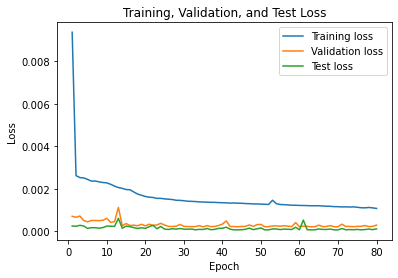

In [85]:
# Graficar las pérdidas
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.show()

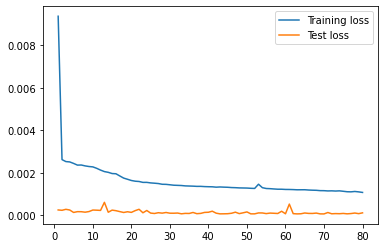

In [86]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

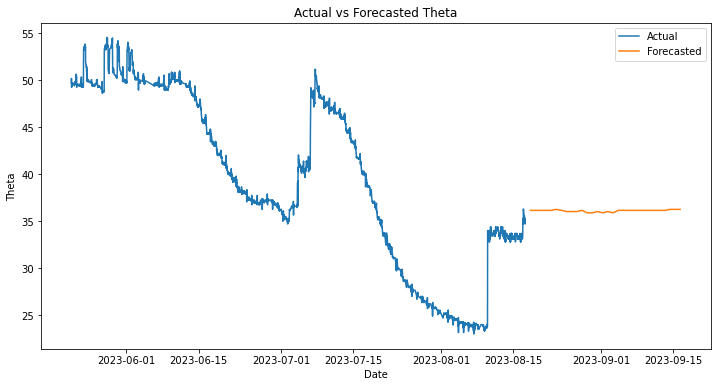

In [100]:
# Definir el número de pasos futuros para pronosticar
num_forecast_steps = 30

# Convertir a NumPy y eliminar dimensiones individuales
sequence_to_plot = X_test_tensor.squeeze().cpu().numpy()  # Usar los datos de prueba tensorizados
historical_data = sequence_to_plot[-1]

# Inicializar una lista para almacenar los valores pronosticados
forecasted_values = []

# Usar el modelo entrenado para pronosticar valores futuros
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Preparar el tensor historical_data
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Usar el modelo para predecir el siguiente valor
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Añadir el valor predicho a la lista forecasted_values
        forecasted_values.append(predicted_value)

        # Actualizar la secuencia historical_data eliminando el valor más antiguo y añadiendo el valor predicho
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Revertir la normalización de los valores pronosticados
forecasted_values = np.array(forecasted_values).reshape(-1, 1)  # Asegurar que los datos estén en el formato adecuado
forecasted_values = scaler.inverse_transform(forecasted_values)  # Revertir la normalización

# Generar fechas futuras
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# Crear un DataFrame para los valores pronosticados revertidos
forecasted_df = pd.DataFrame(data=forecasted_values, index=future_dates, columns=['Forecasted_Theta'])

# Convertir los datos de prueba a arrays de NumPy
actual_values = test_data['Theta'].values

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test_data.index.to_numpy(), actual_values, label='Actual')
plt.plot(forecasted_df.index.to_numpy(), forecasted_df['Forecasted_Theta'].values, label='Forecasted')
plt.xlabel('Date')
plt.ylabel('Theta')
plt.title('Actual vs Forecasted Theta')
plt.legend()
plt.show()


In [101]:
forecasted_df

,Forecasted_Theta
2023-08-18 07:26:08,36.152328
2023-08-19 07:26:08,36.152328
2023-08-20 07:26:08,36.152328
2023-08-21 07:26:08,36.152328
2023-08-22 07:26:08,36.152328
2023-08-23 07:26:08,36.257496
2023-08-24 07:26:08,36.152328
2023-08-25 07:26:08,36.028191
2023-08-26 07:26:08,36.028191
2023-08-27 07:26:08,36.028191
